In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier

SEED = 123
np.random.seed(SEED)

This Notebook includes the classfication model that want to predict whether the restaurant is a Michelin-level restaurant based on the features we create

In [3]:
# load the restaurant details data with 'restaurant_details.csv' generated from 'data_processing.ipynb'
df_details = pd.read_csv('restaurant_details.csv', index_col=0)
df_details

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,transactions,...,category_3,is_michelin,reviews_cnt,elite_reviews_cnt,elite_reviews_perc,user_photo_cnt_avg,user_review_cnt_avg,rating_avg,rating_med,rating_std
0,ce605OMECZ3jLZtk6dCDHA,le-pain-quotidien-new-york-137,Le Pain Quotidien,https://s3-media3.fl.yelpcdn.com/bphoto/z-YqDX...,False,https://www.yelp.com/biz/le-pain-quotidien-new...,84,"[{'alias': 'coffee', 'title': 'Coffee & Tea'},...",3.0,"['pickup', 'delivery']",...,NaN,0,50,16,0.320000,755.900000,199.860000,3.320000,4.0,1.531173
1,B8yFj4qt-HgMCbF5S-GkgA,creperie-new-york-6,Creperie,https://s3-media1.fl.yelpcdn.com/bphoto/uydGkc...,False,https://www.yelp.com/biz/creperie-new-york-6?a...,19,"[{'alias': 'creperies', 'title': 'Creperies'}]",2.5,[],...,NaN,0,19,1,0.052632,654.894737,244.842105,2.631579,2.0,1.300022
2,WZLhPYaYSFy7M_-Jh1VuNw,dos-toros-taqueria-new-york-5,Dos Toros Taqueria,https://s3-media1.fl.yelpcdn.com/bphoto/fNdfBJ...,False,https://www.yelp.com/biz/dos-toros-taqueria-ne...,132,"[{'alias': 'mexican', 'title': 'Mexican'}]",3.5,[],...,NaN,0,50,24,0.480000,3183.000000,365.740000,4.040000,4.0,1.159873
3,tFQRwk9SVOFgpMBZ55UrLw,umami-burger-new-york-17,Umami Burger,https://s3-media2.fl.yelpcdn.com/bphoto/uvquI3...,False,https://www.yelp.com/biz/umami-burger-new-york...,333,"[{'alias': 'burgers', 'title': 'Burgers'}]",3.0,"['delivery', 'pickup']",...,NaN,0,50,34,0.680000,941.800000,424.520000,3.240000,3.5,1.378553
4,jhs35REmv8Yo9-Z27KQJSA,naya-brookfield-place-new-york-3,NAYA - Brookfield Place,https://s3-media3.fl.yelpcdn.com/bphoto/Zd6LgX...,False,https://www.yelp.com/biz/naya-brookfield-place...,32,"[{'alias': 'mediterranean', 'title': 'Mediterr...",4.5,"['pickup', 'delivery']",...,NaN,0,32,15,0.468750,603.875000,252.406250,4.250000,5.0,1.077632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10872,J0V2C6wAkHMLD9j7I50_ZQ,sgd-dubu-so-gong-dong-tofu-and-bbq-edgewater-2,SGD Dubu So Gong Dong Tofu & BBQ,https://s3-media3.fl.yelpcdn.com/bphoto/xX4DnY...,False,https://www.yelp.com/biz/sgd-dubu-so-gong-dong...,228,"[{'alias': 'korean', 'title': 'Korean'}, {'ali...",4.0,['delivery'],...,NaN,0,50,28,0.560000,979.220000,312.580000,3.860000,4.0,1.143036
10873,awvl9pC0RW8PT5A3NeLGMg,fuxingmei-sushi-house-edgewater,FuXingMei Sushi House,https://s3-media1.fl.yelpcdn.com/bphoto/ZgikoA...,False,https://www.yelp.com/biz/fuxingmei-sushi-house...,94,"[{'alias': 'japanese', 'title': 'Japanese'}, {...",4.0,"['delivery', 'pickup']",...,NaN,0,50,16,0.320000,609.660000,186.440000,4.000000,4.0,1.195229
10874,JmhZW6euOW_7L3E3v4fpKg,happy-wok-bronx,Happy Wok,NaN,False,https://www.yelp.com/biz/happy-wok-bronx?adjus...,6,"[{'alias': 'chinese', 'title': 'Chinese'}]",2.0,"['delivery', 'pickup']",...,NaN,0,6,0,0.000000,1.833333,5.833333,2.166667,1.0,1.834848
10875,S55v4pq633nTz7jbGmrCfg,justins-pizza-bronx,Justin's Pizza,https://s3-media2.fl.yelpcdn.com/bphoto/CH79G2...,False,https://www.yelp.com/biz/justins-pizza-bronx?a...,18,"[{'alias': 'pizza', 'title': 'Pizza'}, {'alias...",2.5,"['delivery', 'pickup']",...,NaN,0,18,1,0.055556,3847.222222,312.888889,2.611111,2.0,1.685191


In [4]:
# pick some significant features to do the classification
df_classification = df_details[['restaurant','is_michelin', 'rating', 'review_count', 'category_0', 'price', 'coordinates.latitude', 'coordinates.longitude', 'elite_reviews_perc', 'user_photo_cnt_avg', 'user_review_cnt_avg', 'rating_std']]
# combine the sentiment feature
# the 'data.csv' generated from 'analysis.ipynb', having the sentiment analysis feature
df_nlp = pd.read_csv('data.csv', index_col=0)
df_reviews_classification = pd.merge(df_details, df_nlp[['alias', 'polarity', 'polarity_class']], how='inner', left_index=True, right_index=True)
df_polarity_classification = df_reviews_classification[['restaurant', 'polarity']].groupby('restaurant').mean().rename(columns={'polarity':'polarity_avg'})
df_classification = pd.merge(df_classification, df_polarity_classification, how='inner', on='restaurant')
df_classification.set_index('restaurant', inplace=True)

df_classification

,is_michelin,rating,review_count,category_0,price,coordinates.latitude,coordinates.longitude,elite_reviews_perc,user_photo_cnt_avg,user_review_cnt_avg,rating_std,polarity_avg
restaurant,,,,,,,,,,,,
le-pain-quotidien-new-york-137,0,3.0,84,Coffee & Tea,$$,40.711300,-74.016193,0.320000,755.900000,199.860000,1.531173,0.303960
creperie-new-york-6,0,2.5,19,Creperies,$,40.711547,-74.015400,0.052632,654.894737,244.842105,1.300022,0.300825
dos-toros-taqueria-new-york-5,0,3.5,132,Mexican,$$,40.712342,-74.015280,0.480000,3183.000000,365.740000,1.159873,0.220371
umami-burger-new-york-17,0,3.0,333,Burgers,$$,40.712344,-74.015511,0.680000,941.800000,424.520000,1.378553,-0.019190
naya-brookfield-place-new-york-3,0,4.5,32,Mediterranean,NaN,40.711560,-74.015330,0.468750,603.875000,252.406250,1.077632,0.039393
...,...,...,...,...,...,...,...,...,...,...,...,...
sgd-dubu-so-gong-dong-tofu-and-bbq-edgewater-2,0,4.0,228,Korean,$$,40.818781,-73.976895,0.560000,979.220000,312.580000,1.143036,0.341625
fuxingmei-sushi-house-edgewater,0,4.0,94,Japanese,$$,40.831730,-73.972651,0.320000,609.660000,186.440000,1.195229,0.569375
happy-wok-bronx,0,2.0,6,Chinese,NaN,40.825358,-73.925940,0.000000,1.833333,5.833333,1.834848,0.278200


In [6]:
df_classification['coordinates.latitude'] = pd.to_numeric(df_classification['coordinates.latitude'])
df_classification['coordinates.longitude']= pd.to_numeric(df_classification['coordinates.longitude'])
# check na
df_classification.isna().sum()

is_michelin                 0
rating                      0
review_count                0
category_0                  0
price                    4348
coordinates.latitude        1
coordinates.longitude       1
elite_reviews_perc          0
user_photo_cnt_avg          0
user_review_cnt_avg         0
rating_std                  0
polarity_avg                0
dtype: int64

In [7]:
# fill NAs
df_classification['rating_std'] = df_classification['rating_std'].fillna(0) # if we only get one review, then the std should be 0
df_classification['coordinates.latitude'] = df_classification['coordinates.latitude'].fillna(df_classification['coordinates.latitude'].mean())
df_classification['coordinates.longitude'] = df_classification['coordinates.longitude'].fillna(df_classification['coordinates.longitude'].mean())

/var/folders/gb/wrpqbk497hs6zmqgnpmffmqh0000gn/T/ipykernel_1670/3920590606.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


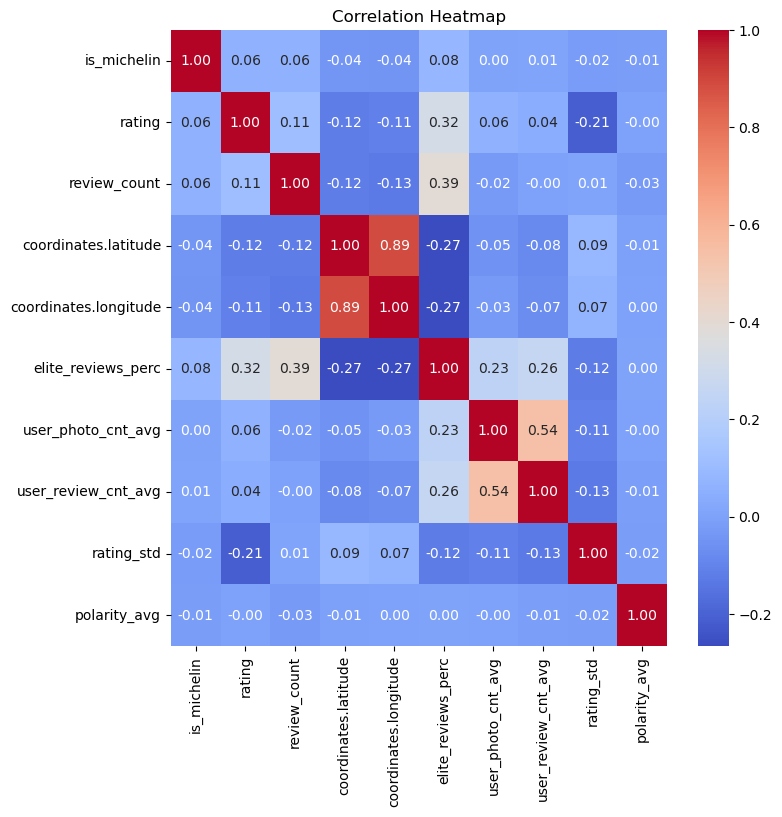

In [10]:
def get_correlation_map(df):
    """
    Show the correlation map of the numerical features in the dataframe
    """
    corr_matrix = df.corr()
    plt.figure(figsize=(8, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap')
    plt.show()

get_correlation_map(df_classification)

Although the coordinates.latitude and coordinates.longitude are highly correlated, we know that they captures different features of the location, so we keep these 2 features. Since 'user_photo_cnt_avg' & 'user_review_cnt_avg' have relatively high correlation (0.54), we drop one of them ('user_photo_cnt_avg').

In [11]:
df_classification = df_classification.drop('user_photo_cnt_avg', axis=1)
df_encoded = pd.get_dummies(df_classification, drop_first=True)
X = df_encoded.drop('is_michelin', axis=1)
y = df_encoded['is_michelin']

# imbalanced data
y.value_counts()

0    10812
1       62
Name: is_michelin, dtype: int64

In [12]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

print("Shape of Training Data:", X_train.shape)
print("Shape of Test Data:", X_test.shape)

Shape of Training Data: (8699, 237)
Shape of Test Data: (2175, 237)


When we try to use a usual classifier to classify an imbalanced dataset, the model favors the majority class due to its larger volume presence. A BalancedBaggingClassifier is the same as a sklearn classifier but with additional balancing. It includes an additional step to balance the training set at the time of fit for a given sampler. This classifier takes two special parameters “sampling_strategy” and “replacement”. The sampling_strategy decides the type of resampling required (e.g. ‘majority’ – resample only the majority class, ‘all’ – resample all classes, etc) and replacement decides whether it is going to be a sample with replacement or not.

In [13]:
# Create our classifier
classifier = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=SEED),
                                sampling_strategy='not majority',
                                n_estimators=50,
                                random_state=SEED)

classifier.fit(X_train, y_train)
preds = classifier.predict(X_test)
print(classification_report(y_test, preds))

/Users/dai/opt/anaconda3/lib/python3.9/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2158
           1       0.40      0.12      0.18        17

    accuracy                           0.99      2175
   macro avg       0.70      0.56      0.59      2175
weighted avg       0.99      0.99      0.99      2175



In [14]:
# check the value counts of our predicted results
pd.DataFrame(preds).value_counts()

0    2170
1       5
dtype: int64

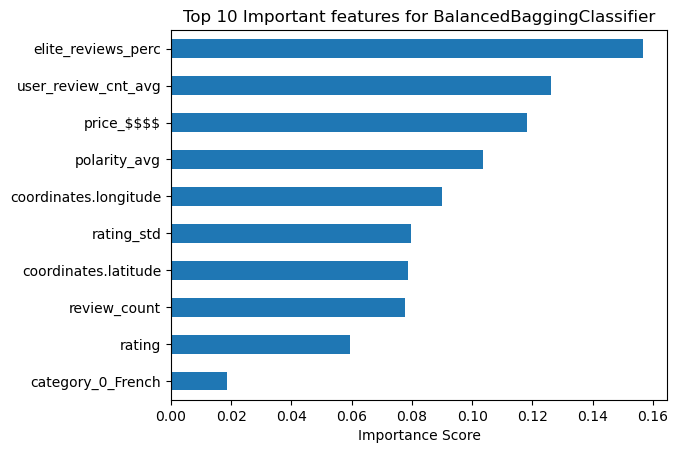

In [15]:
# the mean importance across the estimators
feature_importance = np.mean([est.steps[1][1].feature_importances_ for est in classifier.estimators_], axis=0)
price_mapping = {'price_$$': r'price_\$\$', 'price_$$$': r'price_\$\$\$', 'price_$$$$': r'price_\$\$\$\$'}
features = [price_mapping[i] if i in price_mapping.keys() else i for i in X.columns]
pd.Series(feature_importance, index=features).nlargest(10)[::-1].plot(kind='barh')
plt.xlabel("Importance Score")
plt.title("Top 10 Important features for BalancedBaggingClassifier")
plt.show()